In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;
from scipy.signal import find_peaks
import scipy
from scipy import signal
import librosa
import librosa.display 
import os
import math

In [7]:
from scipy import signal
import csv

In [5]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;



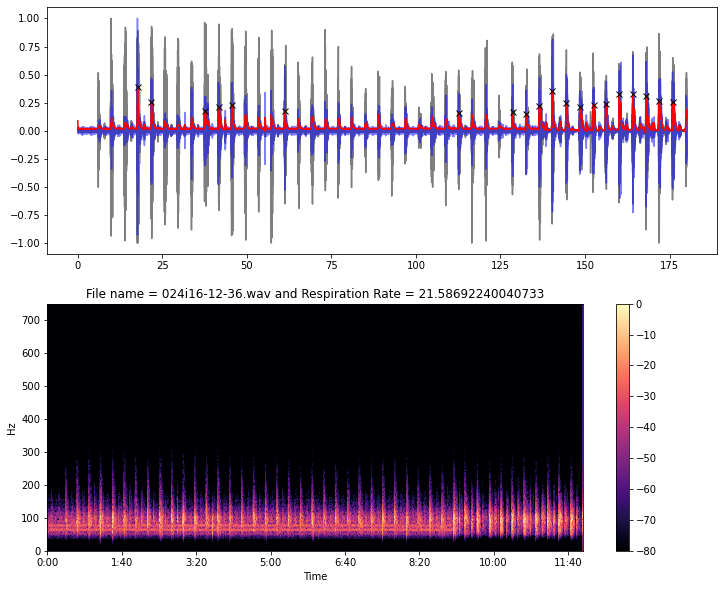

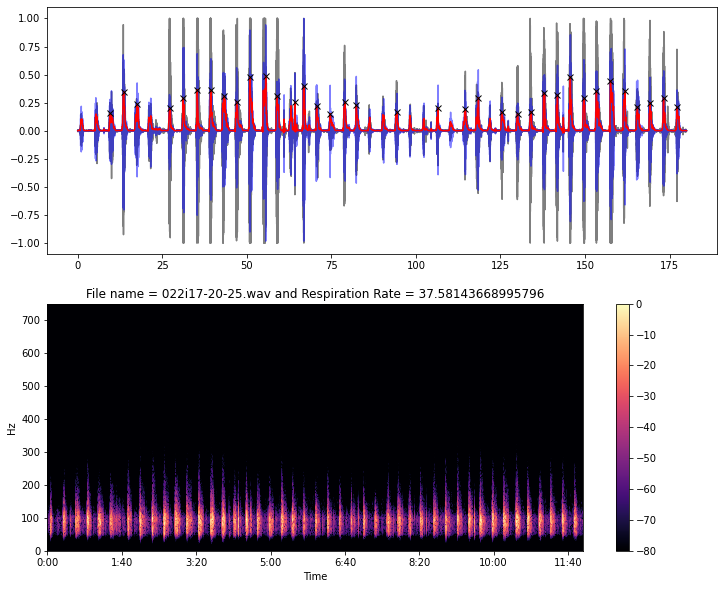

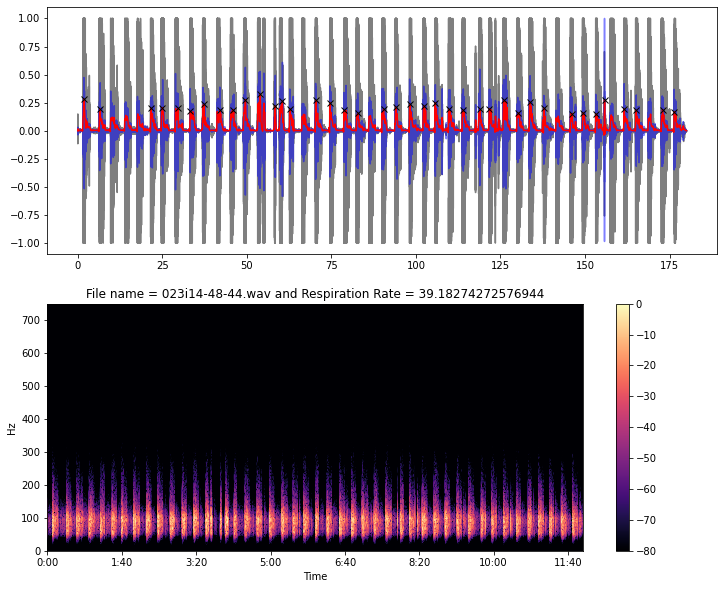

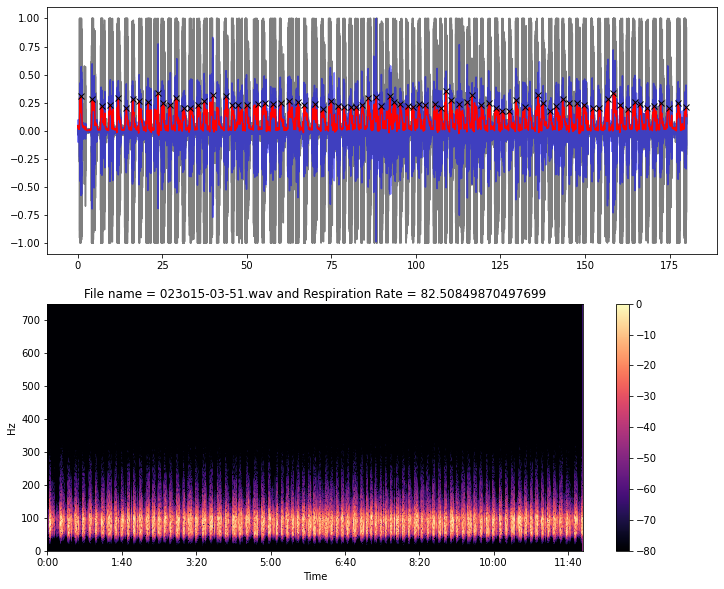

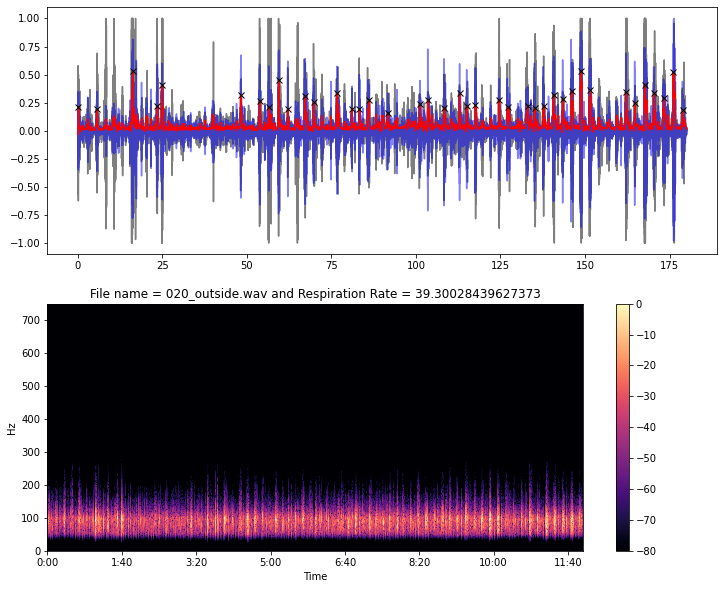

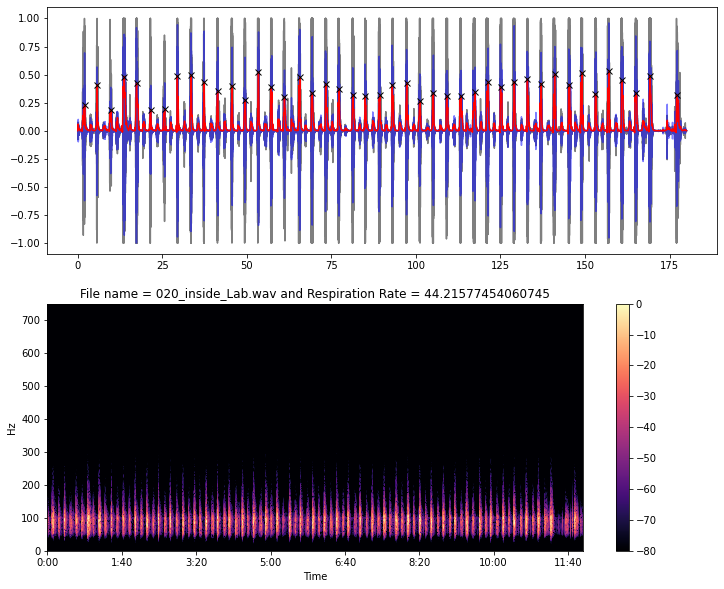

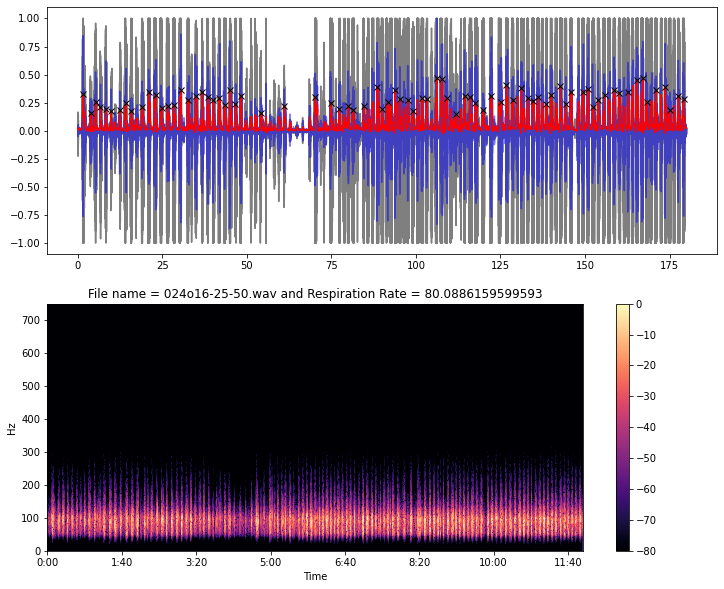

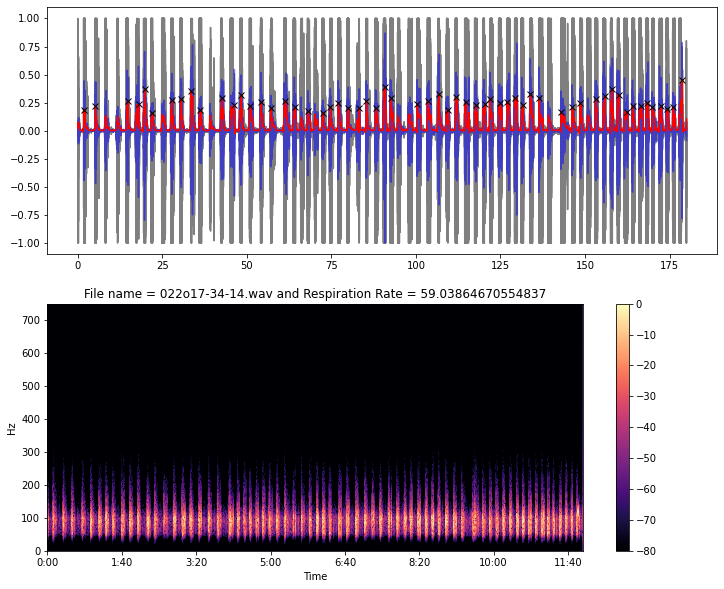

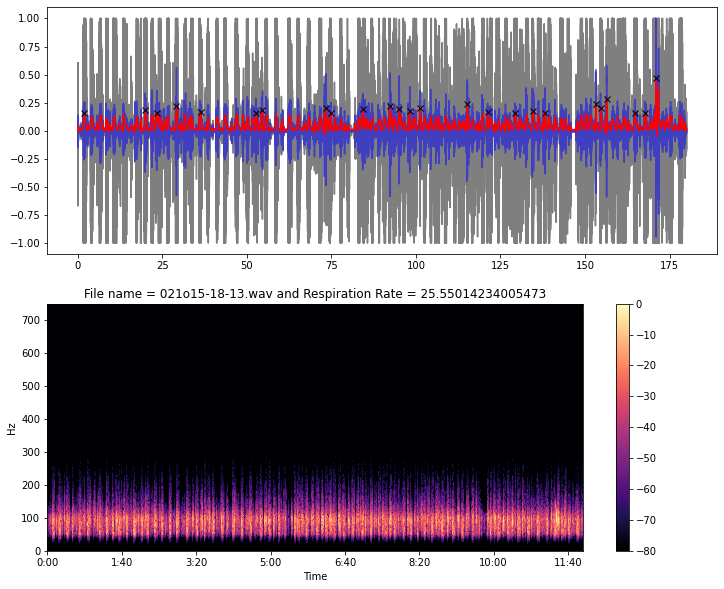

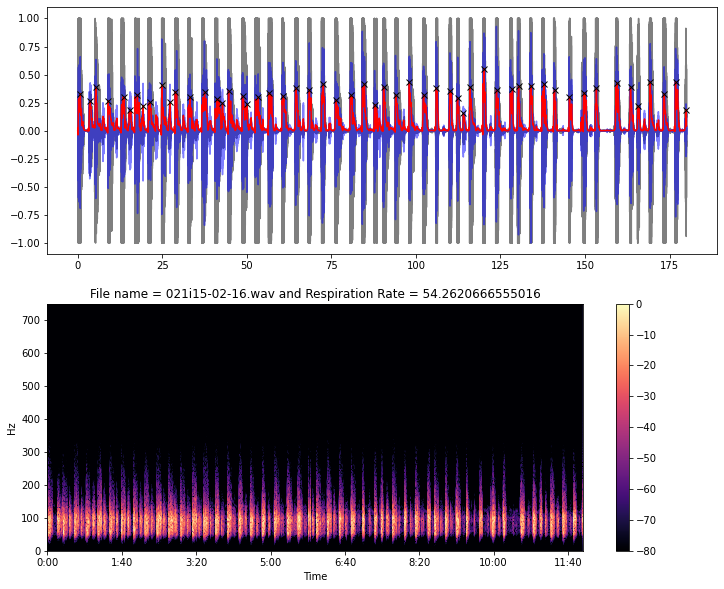

In [59]:


mypath= "Data Collection/"
(_, _, filenames) = next(os.walk(mypath))



cutoff_low = 50
cutoff_high = 100
order = 5
fs = 1500
downsampling_fs = 1000
respiration_rate = 0
for file in filenames[:]:
    if file.split('.')[1]== 'wav':
        tidal, sr = librosa.load(mypath+file, sr=1500)
        
        #*************uncomment for downsampling*************
        #tidal = scipy.signal.decimate(tidal,int(fs/downsampling_fs))
        
        
        #select time: 2-5 minute is metronome
        tidal = tidal[sr*120:sr*300]
        
        tidal_t = [s/fs for s in range(0,len(tidal))]
        #filtering using band passfilter
        tidal_f = butter_bandpass_filter(tidal,cutoff_low,cutoff_high,fs,order)
        #normalizing the waveform
        #print(max(abs(tidal_f.max()),abs(tidal_f.min())))
        tidal_f = tidal_f/max(abs(tidal_f.max()),abs(tidal_f.min()))
        
        #apply hilbert transform
        x_filt_hilbert = signal.hilbert(tidal_f)
        envelope_hat = np.abs(x_filt_hilbert)
        #filter the Hilbert envelope
        nyq_rate = fs /0.5
        width = 1.0/nyq_rate # 5 Hz filter transition width.
        ripple_db = 10.0 # stop band attenuation
        fL_hz = 20
        N, beta = signal.kaiserord(ripple_db, width)
        taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
        envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
        peaks,_ = find_peaks(envelope_hat_filt,prominence = 0.04,distance= 2000,height = 0.15)
        #calculate fft and spectogram
        freqs,mags = compute_fft(tidal_f,fs) ########
        D = librosa.stft(tidal_f,n_fft = 1024,win_length = 512)  # STFT of y ######################
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
      
        #for respiration rate estimation
        if(len(peaks) > 1): #if the number of peaks in a recording are more than 1 (else consider respiration rate(rr) = 0)
          peak_to_peak = (tidal_t[peaks[len(peaks)-1]]-tidal_t[peaks[0]])/(len(peaks)-1) # average difference between the first and last peak 
          respiration_rate = max(tidal_t)/peak_to_peak # (total time interval till last peak) / (average difference between the first and last peak)

        fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,10))
        ax1.plot(tidal_t, tidal,'k', alpha=0.5);
        ax1.plot(tidal_t,tidal_f, 'b', alpha=0.5)
        ax1.plot(tidal_t,envelope_hat_filt,'r');
        ax1.plot([tidal_t[peak] for peak in peaks], [envelope_hat_filt[i] for i in peaks], "x", color='black')
        #ax2.plot(freqs,mags)
        img = librosa.display.specshow(S_db,y_axis='linear',sr=fs,x_axis='time', ax=ax2)
        fig.colorbar(img, ax=ax2)
        ax2.label_outer()
        ax2.set_title("File name = {} and Respiration Rate = {}".format(file, respiration_rate))
        #plt.savefig('data-tidal-breathing/{}.png'.format(file))

In [49]:
filenames

['024i16-12-36.wav',
 '020_outdoor.csv',
 '020_indoor.csv',
 '022i17-20-25.wav',
 '023i14-48-44.wav',
 '023o15-03-51.wav',
 '022_indoor.csv',
 '020_outside.wav',
 '023_outdoor.csv',
 '020_inside_Lab.wav',
 'Readme.md',
 '024_outdoor.csv',
 '024_indoor.csv',
 '024o16-25-50.wav',
 '021_outdoor.csv',
 '021_indoor.csv',
 '022o17-34-14.wav',
 '021o15-18-13.wav',
 '022_outdoor.csv',
 '021i15-02-16.wav',
 '023_indoor.csv']